In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
dataset_name = 'prepared_facebook_data'
folder_name = 'facebook_comm_vol'
DIR_WITH_FILES= '../other_data_experiments/{}/'.format(folder_name)

In [3]:
grid_df = pd.read_csv(DIR_WITH_FILES+'res_grid_search_{}.csv'.format(dataset_name))
default_df = pd.read_csv(DIR_WITH_FILES+'res_default_{}.csv'.format(dataset_name))

group_df=pd.DataFrame([])
for i in range(1,11):
    df = pd.read_csv(DIR_WITH_FILES+\
                     'res_rand_groups_{}_{}.csv'.format(dataset_name, i))
    df['iter_num'] = range(1, df.shape[0]+1)    
    
    max_score_for_first_group_idx = df.loc[0:244, 'mean_test_score'].idxmax()
    params = eval(df.loc[max_score_for_first_group_idx, 'params'])
    max_depth = params['max_depth']
    min_child_weight = params['min_child_weight']

    df.loc[:, 'param_max_depth'].fillna(max_depth, inplace=True)
    df.loc[:, 'param_min_child_weight'].fillna(min_child_weight, inplace=True)
    
    max_score_for_first_group_idx = df.loc[244:243*2, 'mean_test_score'].idxmax()
    params = eval(df.loc[max_score_for_first_group_idx, 'params'])    
    param_lambda = params['lambda']
    param_alpha = params['alpha']

    df.loc[:, 'param_lambda'].fillna(param_lambda, inplace=True)
    df.loc[:, 'param_alpha'].fillna(param_alpha, inplace=True)
    
    max_score_for_first_group_idx = df.loc[243*2+1:, 'mean_test_score'].idxmax()
    params = eval(df.loc[max_score_for_first_group_idx, 'params'])
    param_subsample = params['subsample']
    param_colsample_bytree = params['colsample_bytree']

    df.loc[:, 'param_subsample'].fillna(param_subsample, inplace=True)
    df.loc[:, 'param_colsample_bytree'].fillna(param_colsample_bytree, inplace=True)

    group_df = pd.concat([group_df, df], sort=False)
    
random_df=pd.DataFrame([])
for i in range(1,11):
    df = pd.read_csv(DIR_WITH_FILES+\
                     'res_rand_{}_{}.csv'.format(dataset_name, i))    
    df['iter_num'] = range(1, df.shape[0]+1)    
    
    random_df = pd.concat([random_df, df], sort=False)

In [4]:
df = pd.concat([default_df, grid_df, group_df, random_df], sort=False)

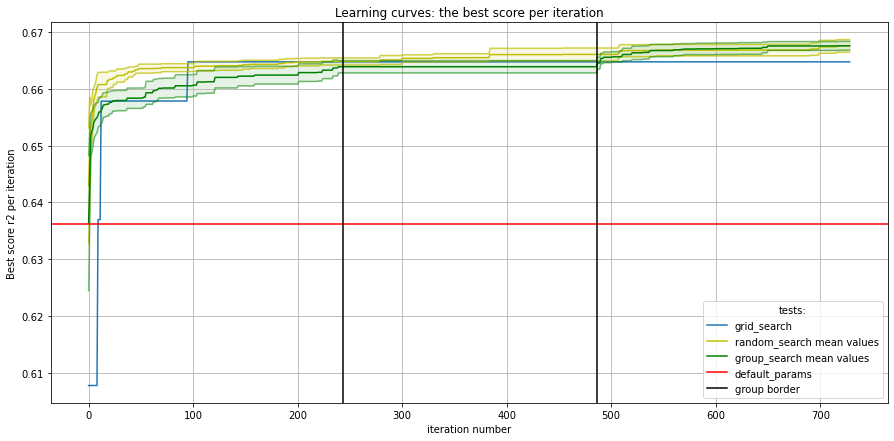

In [7]:
#comparison
# confidence intervals theory get from: 
# https://medium.com/ml-ai-study-group/confidence-interval-confidence-level-be58d250dd40


## GRID_SEARCH
#get best scores per itration for grid_search performance:
grid_perf=grid_df.loc[grid_df['experiment_name']!='default params', 'mean_test_score'].cummax()


## RANDOM_SEARCH
#get best scores per itration for each random_search performance:
random_mean=pd.DataFrame([])
for i in random_df.run_number.unique():
    tmp=pd.DataFrame(random_df.loc[random_df.run_number==i, 
                                   "mean_test_score"].copy().cummax())
    tmp["iter_num"]=random_df.loc[random_df.run_number==i, "iter_num"]
    random_mean=pd.concat([random_mean, tmp], sort=False)
    
#get mean and confidence interval value for random_search performance on iteration:    

z = 1.96 # for 95% conf interval (coefficient)
# z = 1.64 # for 90% conf interval

n=random_mean.shape[0]/random_mean.iter_num.max() # now n=9, because 4 runs were made for random search
random_std=random_mean.groupby(by="iter_num")['mean_test_score'].std() #std
random_std=(random_std*z)/np.sqrt(n) #confidence interval value 
random_mean=random_mean.groupby(by="iter_num")['mean_test_score'].mean() #mean


## GROUP_SEARCH
#get best scores per itration for each group_search performance (same computations):
group_mean=pd.DataFrame([])
for i in group_df.run_number.unique():
    tmp=pd.DataFrame(group_df.loc[group_df.run_number==i, "mean_test_score"].cummax())
    tmp["iter_num"]=group_df.loc[group_df.run_number==i, "iter_num"]
    group_mean=pd.concat([group_mean, tmp], sort=False)

n=group_mean.shape[0]/group_mean.iter_num.max() # now n=10
group_std=group_mean.groupby(by="iter_num")['mean_test_score'].std()
group_std=(group_std*z)/np.sqrt(n) 
group_mean=group_mean.groupby(by="iter_num")['mean_test_score'].mean()

## DEFAULT performance
default_perf=default_df['mean_test_score']


## PLOT
plt.figure(figsize=(15,7))
plt.grid()
x=list(range(0, grid_perf.shape[0]))

#grid plot:
plt.plot(x, grid_perf, label="grid_search")

#conf for random:
plt.plot(x, random_mean, color="y", label="random_search mean values")
lower_random=random_mean - random_std
upper_random=random_mean + random_std
plt.plot(x, lower_random, alpha=0.7, color="y")
plt.plot(x, upper_random, alpha=0.7, color="y")
plt.fill_between(x, lower_random, upper_random, alpha=0.1, color="y") 

#conf for group:
plt.plot(x, group_mean, color="green", label="group_search mean values")
lower_group=group_mean - group_std
upper_group=group_mean + group_std
plt.plot(x, lower_group, alpha=0.5, color="green")
plt.plot(x, upper_group, alpha=0.5, color="green")
plt.fill_between(x, lower_group, upper_group, alpha=0.1, color="green")

#line for default values
plt.axhline(default_perf.values, label="default_params", color='r')

plt.axvline(243, label="group border", color='k')
plt.axvline(243*2, color='k')

plt.legend(title='tests:')
plt.title("Learning curves: the best score per iteration")
plt.ylabel("Best score r2 per iteration")
plt.xlabel("iteration number")
plt.savefig(DIR_WITH_FILES+"graphs/scores.jpg")
plt.show()

In [8]:
df.loc[df.experiment_name.astype(str).str.contains('default'),[
    'param_alpha', 'param_colsample_bytree', 'param_lambda',
       'param_min_child_weight', 'param_subsample']]=[0,1,1,1,1]

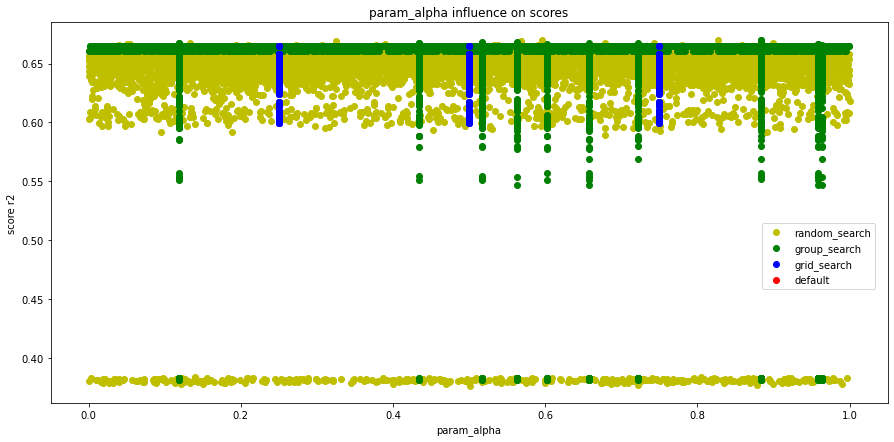

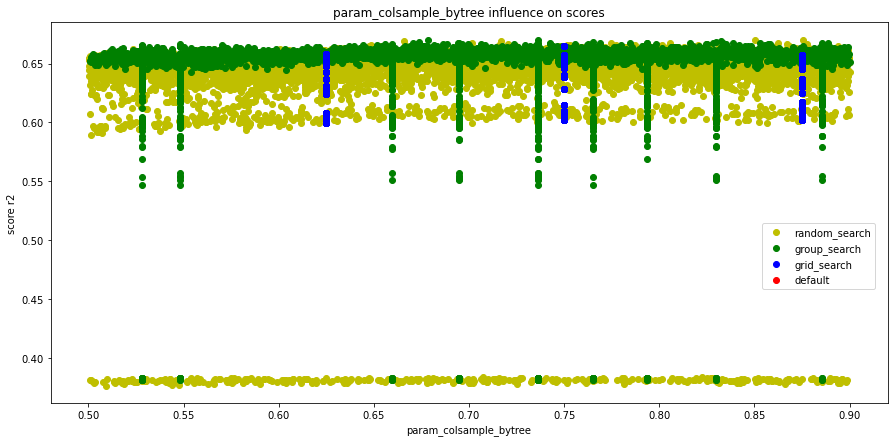

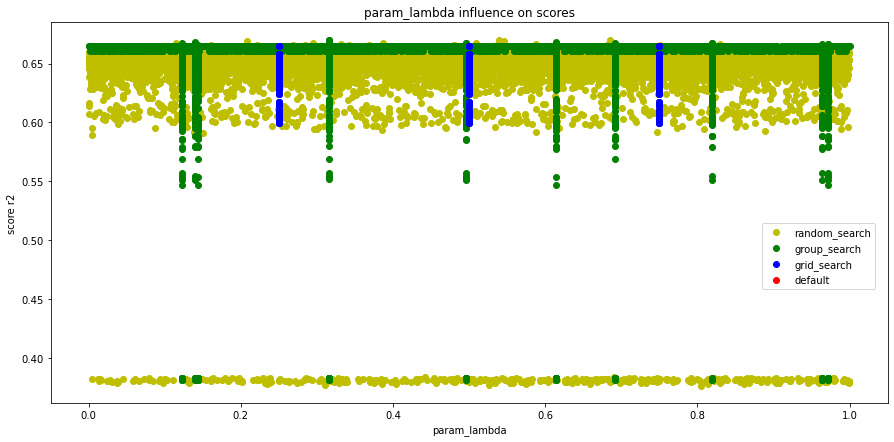

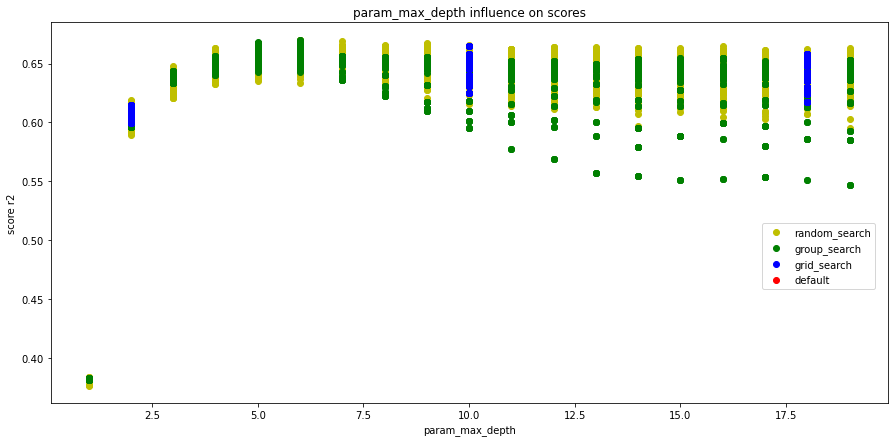

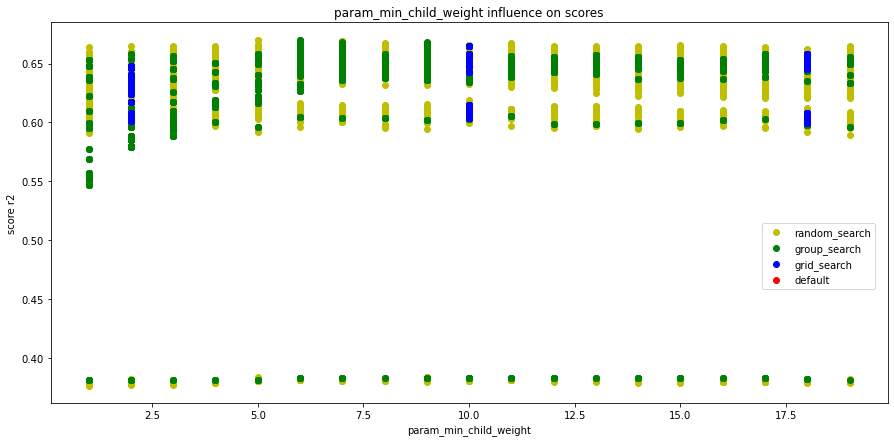

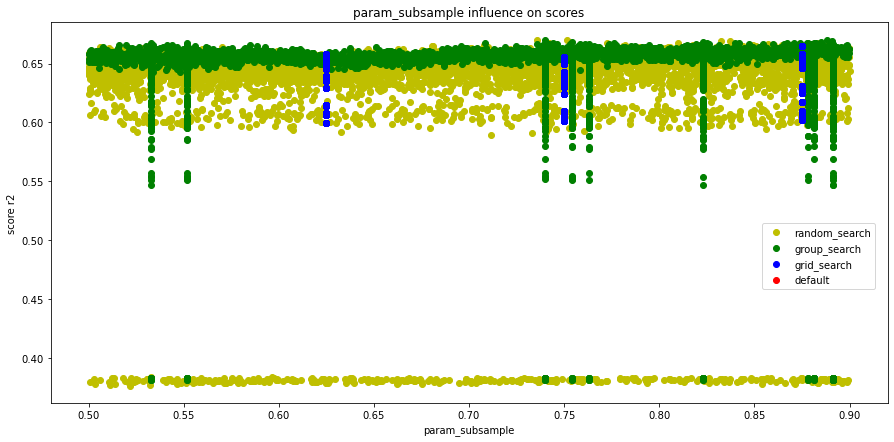

In [22]:
#params influence
params_list=['param_alpha', 'param_colsample_bytree',
             'param_lambda', 'param_max_depth',
       'param_min_child_weight', 'param_subsample']

df.loc[df.experiment_name.astype(str).str.contains("group"), 
       "experiment_name"] = "group_search"


exp_list = ("random_search", "group_search", "grid_search", "default")
color_list = ("y","green", "b", "r")
for param in params_list:    
    plt.figure(figsize=(15,7))  
    
    for exp_name, color in zip(exp_list, color_list):            
        data = df.loc[df.experiment_name == exp_name]
        x=data.loc[:,param]
        y=data.loc[:,'mean_test_score']
        plt.scatter(x, y, color = color, alpha=1, label = exp_name)
        
    plt.title(param+" influence on scores")
    plt.xlabel(param)
    plt.ylabel("score r2")
    plt.legend(loc=(0.85,0.3))
    plt.savefig(DIR_WITH_FILES+"graphs/{} influence in {}.jpg".format(param, dataset_name))
    plt.show()

In [10]:
best_scores = df.groupby(by = ['experiment_name', 'run_number']
                        )['mean_test_score'].max()

In [11]:
best_iter = df.merge(best_scores, 
                     on =['experiment_name', 'run_number', 'mean_test_score']
                    ).groupby(['experiment_name','run_number'])['iter_num'].min()

In [12]:
best_info = pd.concat([best_iter, best_scores],join='inner', axis = 1)

In [13]:
best_info.reset_index()

,experiment_name,run_number,iter_num,mean_test_score
0,group_search,1.0,646.0,0.667022
1,group_search,2.0,567.0,0.667483
2,group_search,3.0,621.0,0.666785
3,group_search,4.0,521.0,0.668525
4,group_search,5.0,600.0,0.667158
5,group_search,6.0,538.0,0.667620
6,group_search,7.0,719.0,0.667778
7,group_search,8.0,582.0,0.670311
8,group_search,9.0,569.0,0.665503
9,group_search,10.0,623.0,0.668176


In [14]:
df.merge(best_info.reset_index(), 
         how = 'inner', 
         on =['experiment_name', 'run_number', 'iter_num', 'mean_test_score']
        )[
    ['experiment_name', #'run_number', 'iter_num', 'mean_test_score',
     'param_max_depth', 'param_min_child_weight', 'params']
].drop_duplicates()

,experiment_name,param_max_depth,param_min_child_weight,params
0,group_search,6.0,9.0,"{'colsample_bytree': 0.6593131897321308, 'subs..."
1,group_search,6.0,9.0,"{'colsample_bytree': 0.6949874681385145, 'subs..."
2,group_search,6.0,9.0,"{'colsample_bytree': 0.5479440173456046, 'subs..."
3,group_search,6.0,9.0,"{'colsample_bytree': 0.7651935347982279, 'subs..."
4,group_search,6.0,9.0,"{'colsample_bytree': 0.7935840711805073, 'subs..."
5,group_search,6.0,9.0,"{'colsample_bytree': 0.7363917983057237, 'subs..."
6,group_search,6.0,9.0,"{'colsample_bytree': 0.885662892538855, 'subsa..."
7,group_search,6.0,6.0,"{'colsample_bytree': 0.7361086152460705, 'subs..."
8,group_search,6.0,9.0,"{'colsample_bytree': 0.5281260633468016, 'subs..."
9,group_search,5.0,7.0,"{'colsample_bytree': 0.8296622512940521, 'subs..."


In [15]:
best_scores.reset_index().groupby(
    'experiment_name')['mean_test_score'].agg(['mean', 'std'])

,mean,std
experiment_name,,
group_search,0.667636,0.001254
random_search,0.667610,0.001797
